Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Provide full answers for each question, including interpretation of the results. Each question is worth 25 points.

This homework is due on Friday, December 8, 2017.

## Question 1

The `titanic.xls` spreadsheet in the `data` directory contains data regarding the passengers on the Titanic when it sank in 1912. A recent [Kaggle competition](http://www.kaggle.com/c/titanic-gettingStarted) was based on predicting survival for passengers based on the attributes in the passenger list. 

Use scikit-learn to build both a support vector classifier and a logistic regression model to predict survival on the Titanic. Use cross-validation to assess your models, and try to tune them to improve performance.

Discuss the benefits and drawbacks of both approaches for application to such problems.

In [1]:
# Write your work here
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# for windows
# file = 'C:/Users/Rui/source/BIOS_8366/data/titanic.xls'
# for mac
file = '/Users/ruiwang/source/BIOS_8366/data/titanic.xls'
data = pd.read_excel(file)
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


0    0.618029
1    0.381971
Name: survived, dtype: float64


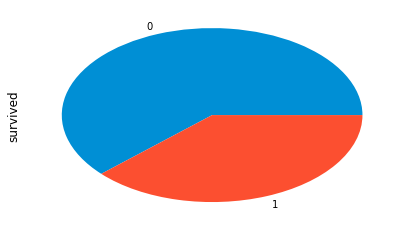

In [77]:
# look at the distribution of our interest: isbadbuy
prop = data['survived'].value_counts()/len(data)
print(prop)
prop.plot(kind = 'pie')

### Data cleaning

In [3]:
for i in data:
    data['initial']=data.name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
# replace intials with spelling error
data['initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess',
                         'Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other',
                         'Other','Other','Mr','Mr','Mr','Mr'],inplace=True)
data.groupby('initial')['age'].mean() #lets check the average age by Initials

## Assigning the NaN Values with the Ceil values of the mean ages
data.loc[(data.age.isnull())&(data.initial=='Mr'),'age']=33
data.loc[(data.age.isnull())&(data.initial=='Mrs'),'age']=36
data.loc[(data.age.isnull())&(data.initial=='Master'),'age']=5
data.loc[(data.age.isnull())&(data.initial=='Miss'),'age']=22
data.loc[(data.age.isnull())&(data.initial=='Other'),'age']=46

# As we saw that maximum passengers boarded from Port S, we replace NaN with S.
data['embarked'].fillna('S',inplace=True)
data['age_band']=0
data.loc[data['age']<=16,'age_band']=0
data.loc[(data['age']>16)&(data['age']<=32),'age_band']=1
data.loc[(data['age']>32)&(data['age']<=48),'age_band']=2
data.loc[(data['age']>48)&(data['age']<=64),'age_band']=3
data.loc[data['age']>64,'age_band']=4

data['family_size']=0
data['family_size']=data['parch']+data['sibsp'] #family size
data['alone']=0
data.loc[data.family_size==0,'alone']=1 #Alone

#data['Fare_Range']=pd.qcut(data['fare'],4)
#data.groupby(['Fare_Range'])['survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

data['fare_cat']=0
data.loc[data['fare']<=7.91,'fare_cat']=0
data.loc[(data['fare']>7.91)&(data['fare']<=14.454),'fare_cat']=1
data.loc[(data['fare']>14.454)&(data['fare']<=31),'fare_cat']=2
data.loc[(data['fare']>31)&(data['fare']<=513),'fare_cat']=3

data['sex'].replace(['male','female'],[0,1],inplace=True)
data['embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['initial'].replace(['Mr','Mrs','Miss','Master','Other'], [0,1,2,3,4], inplace=True)
data.drop(['name','ticket','cabin', 'age', 'fare', 'home.dest', 'boat', 'body'],axis=1,inplace=True)

# rearrange the columns
data = data[['survived', 'pclass', 'sex', 'sibsp', 'parch', 'embarked', 
             'initial', 'age_band', 'family_size', 'alone', 'fare_cat']]

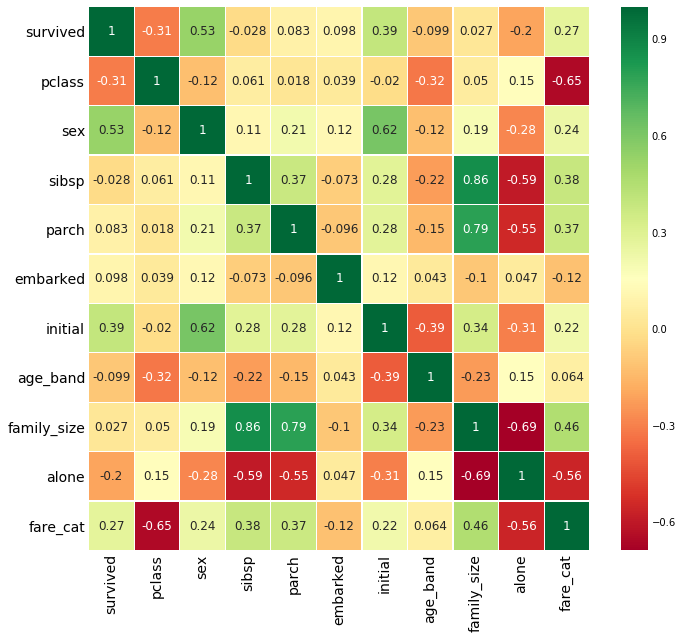

In [4]:
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':12})
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Modeling

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

y = data['survived'].values
X = data.drop(['survived'], axis = 1).values
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [139]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Support Vector Classifier

Best parameters set found on development set:

{'C': 46.415888336127821, 'gamma': 0.00012915496650148841, 'kernel': 'rbf'}

Best score set found on development set:

Detailed classification report:

             precision    recall  f1-score   support

          0       0.96      0.93      0.94        98
          1       0.96      0.98      0.97       187

avg / total       0.96      0.96      0.96       285



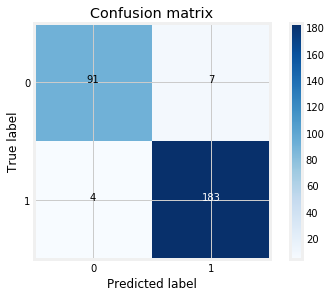

In [140]:
tuned_parameters={'kernel':['rbf','linear'],
                  'C': np.logspace(-5, 5, 10),
                  'gamma':np.logspace(-5, 5, 10)}

scores = ['accuracy']

clf = GridSearchCV(SVC(max_iter=1000, tol = 1e-6, random_state = 42), 
                   tuned_parameters, cv=5, n_jobs = -1,
                  scoring='%s' % score)
clf.fit(X_train, y_train)
y_true, y_pred = y_test, clf.predict(X_test)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Best score set found on development set:")
print()
print("Detailed classification report:")
print()
print(classification_report(y_true, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes = np.array(["0", "1"]))

Best parameters set found on development set:

{'C': 46.415888336127821, 'gamma': 0.00012915496650148841, 'kernel': 'rbf'}

Best score set found on development set:

Detailed classification report:

             precision    recall  f1-score   support

          0       0.96      0.93      0.94        98
          1       0.96      0.98      0.97       187

avg / total       0.96      0.96      0.96       285



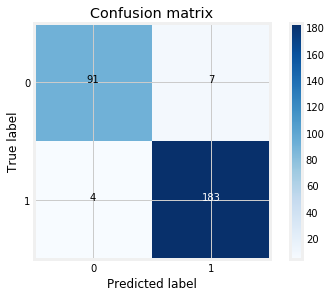

In [141]:
tuned_parameters={'kernel':['rbf','linear'],
                  'C': np.logspace(-5, 5, 10),
                  'gamma':np.logspace(-5, 5, 10)}

scores = ['f1']

clf = GridSearchCV(SVC(max_iter=1000, tol = 1e-6, random_state = 42), 
                   tuned_parameters, cv=5, n_jobs = -1,
                  scoring='%s' % score)
clf.fit(X_train, y_train)
y_true, y_pred = y_test, clf.predict(X_test)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Best score set found on development set:")
print()
print("Detailed classification report:")
print()
print(classification_report(y_true, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes = np.array(["0", "1"]))

### Logistic Regreesion Classifier

Best parameters set found on development set:

{'C': 573.61525104486816, 'penalty': 'l2'}

Best score set found on development set:

Detailed classification report:

             precision    recall  f1-score   support

          0       0.94      0.96      0.95        98
          1       0.98      0.97      0.97       187

avg / total       0.97      0.96      0.96       285




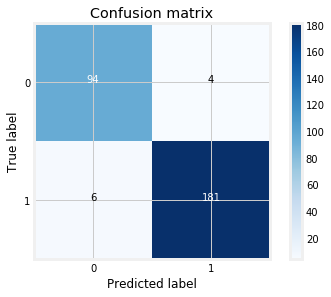

In [142]:
tuned_parameters = { 'C': np.logspace(-5, 10, 30),
                   'penalty': ['l1', 'l2'],
                   }

scores = ['accuracy']

clf = GridSearchCV(LogisticRegression(max_iter=1000, tol = 1e-6, random_state = 42), 
                   tuned_parameters, cv=5, n_jobs = -1,
                  scoring='%s' % score)
clf.fit(X_train, y_train)
y_true, y_pred = y_test, clf.predict(X_test)
labels = [0, 1]

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Best score set found on development set:")
print()
print("Detailed classification report:")
print()
print(classification_report(y_true, y_pred))
print()
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes = np.array(["0", "1"]))

Best parameters set found on development set:

{'C': 573.61525104486816, 'penalty': 'l2'}

Best score set found on development set:

Detailed classification report:

             precision    recall  f1-score   support

          0       0.94      0.96      0.95        98
          1       0.98      0.97      0.97       187

avg / total       0.97      0.96      0.96       285




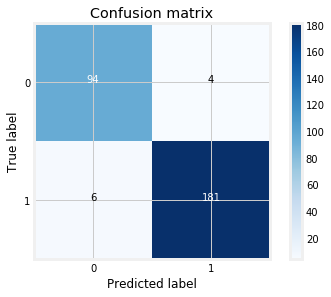

In [143]:
tuned_parameters = { 'C': np.logspace(-5, 10, 30),
                   'penalty': ['l1', 'l2'],
                   }

scores = ['f1']

clf = GridSearchCV(LogisticRegression(max_iter=1000, tol = 1e-6, random_state = 42), 
                   tuned_parameters, cv=5, n_jobs = -1,
                  scoring='%s' % score)
clf.fit(X_train, y_train)
y_true, y_pred = y_test, clf.predict(X_test)
labels = [0, 1]

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Best score set found on development set:")
print()
print("Detailed classification report:")
print()
print(classification_report(y_true, y_pred))
print()
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes = np.array(["0", "1"]))

### Model Comparison

Discuss the benefits and drawbacks of both approaches for application to such problems.

a. Linear SVMs and logistic regression generally perform comparably in practice. Use SVM with a nonlinear kernel if you have reason to believe your data won't be linearly separable (or you need to be more robust to outliers than LR will normally tolerate). Otherwise, just try logistic regression first and see how you do with that simpler model. If logistic regression fails you, try an SVM with a non-linear kernel like a RBF. 

b. Set $p$ as number of features and $n$ as number of training examples. 

    1. If p >> n, apply logistic regression or linear SVMs.
    2. If p is small and n is intermediate, use SVM with a nonlinear kernel.
    3. If n >> p, create or add more features will help and then use logistics regression or linear SVMs.
    
c. Neural network likely to work well for most of these settings but might be slower to train.

## Question 2

The file `TNNASHVI.txt` in your data directory contains daily temperature readings for Nashville, courtesy of the [Average Daily Temperature Archive](http://academic.udayton.edu/kissock/http/Weather/). This data, as one would expect, oscillates annually. Using PyMC3, use a Gaussian process to fit a non-parametric regression model to this data, choosing an appropriate covariance function. Plot 10 regression lines drawn from your process.

In [2]:
%matplotlib inline
from sklearn.datasets import load_diabetes
import pandas as pd

daily_temps = pd.read_table("../data/TNNASHVI.txt", sep='\s+', 
                            names=['month','day','year','temp'], na_values=-99)



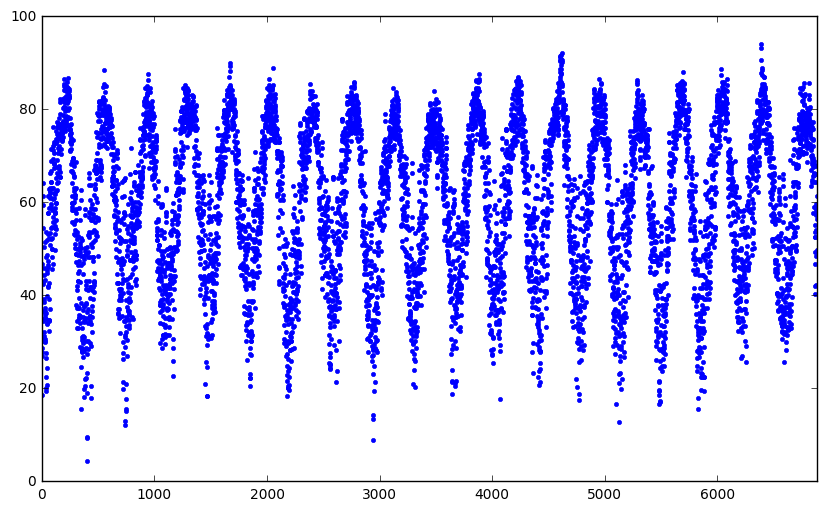

In [3]:
daily_temps.temp.plot(style='b.', figsize=(10,6), grid=False)

In [4]:
# Write your answer here

## Question 3

Fit a series of random-forest classifiers to the Wisconsin breast cancer dataset (`wisconsin_breast_cancer.csv`), to explore the sensitivity to the parameters `max_features`, the number of variables considered for splitting at each step, `max_depth`, the maximum depth of the tree, and `n_estimators`, the number of trees in the forest. Use apprpriate metrics of performance, and include plots against a suitably-chosen range of values for these parameters.

Dataset description: Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. Ten real-valued features are computed for each cell nucleus:

- `radius` (mean of distances from center to points on the perimeter) 
- `texture` (standard deviation of gray-scale values) 
- `perimeter` 
- `area` 
- `smoothness` (local variation in radius lengths) 
- `compactness` (perimeter^2 / area - 1.0) 
- `concavity` (severity of concave portions of the contour) 
- `concave points` (number of concave portions of the contour) 
- `symmetry` 
- `fractal dimension` ("coastline approximation" - 1)

The outcome to be predicted is tumor type (M = malignant, B = benign).

In [51]:
# Write your work here
file = '/Users/ruiwang/source/BIOS_8366/data/wisconsin_breast_cancer.csv'
df = pd.read_csv(file)
df['diagnosis'].replace(['M','B'],[0,1],inplace=True)
df.drop(['id'], axis = 1, inplace = True)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


1    0.627417
0    0.372583
Name: diagnosis, dtype: float64


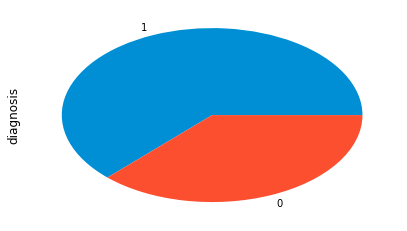

In [78]:
# look at the distribution of our interest: isbadbuy
prop = df['diagnosis'].value_counts()/len(df)
print(prop)
prop.plot(kind = 'pie')

From the above pie figure, the target we predict is almost a balanced dataset (63% vs 37%). Our prediction target is whether the breast cancer is malignant (1) or benign (0). For these similar problems, the analysis is sensitive to the false negative, which can be translated by several metrics like precision ($\frac {tp}{tp+fn}$), accuracy ($\frac {tn + tp} {tn + tp + fn + fp}$) or f1 score ($2*\frac {recall*precision}{recall + precision}$).

For classification, it is better to plot the confusion matrix or precision-recall curve (ROC curve).

#### Use recall as scoring to do parameter optimization.

Best parameters set found on development set:

{'max_depth': 10, 'max_features': 5, 'n_estimators': 10}

Best score set found on development set:

Detailed classification report:

             precision    recall  f1-score   support

          0       0.97      0.94      0.95        63
          1       0.96      0.98      0.97       108

avg / total       0.96      0.96      0.96       171




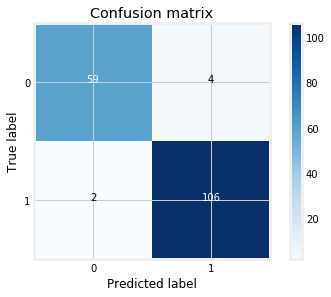

In [149]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


y = df['diagnosis'].values
X = df.drop(['diagnosis'], axis = 1).values
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# specify parameters and distributions to sample from
tuned_parameters = {"n_estimators": [10, 20, 50, 100, 500], 
                    "max_depth": [3, 5, 10, 20], 
                    "max_features": [1, 3, 5, 10]
                    }

scores = ['recall']

clf = GridSearchCV(RandomForestClassifier(), 
                   tuned_parameters,
                   cv=5, n_jobs = -1, scoring='%s' % score)
clf.fit(X_train, y_train)
y_true, y_pred = y_test, clf.predict(X_test)

labels = [0, 1]

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Best score set found on development set:")
print()
print("Detailed classification report:")
print()
print(classification_report(y_true, y_pred))
print()
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes = np.array(["0", "1"]))   

#### Use accuracy as scoring to do parameter optimization.

Best parameters set found on development set:

{'max_depth': 20, 'max_features': 10, 'n_estimators': 100}

Best score set found on development set:

Detailed classification report:

             precision    recall  f1-score   support

          0       0.97      0.94      0.95        63
          1       0.96      0.98      0.97       108

avg / total       0.96      0.96      0.96       171




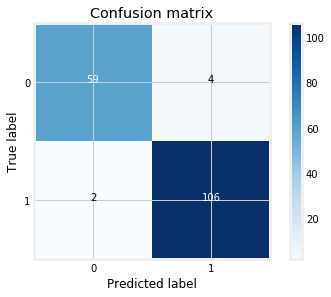

In [150]:
# specify parameters and distributions to sample from
tuned_parameters = {"n_estimators": [10, 20, 50, 100, 500], 
                    "max_depth": [3, 5, 10, 20], 
                    "max_features": [1, 3, 5, 10]
                    }

scores = ['accuracy']

clf = GridSearchCV(RandomForestClassifier(), 
                   tuned_parameters,
                   cv=5, n_jobs = -1, scoring='%s' % score)
clf.fit(X_train, y_train)
y_true, y_pred = y_test, clf.predict(X_test)

labels = [0, 1]

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Best score set found on development set:")
print()
print("Detailed classification report:")
print()
print(classification_report(y_true, y_pred))
print()
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes = np.array(["0", "1"]))  

#### Use f1 score as scoring to do parameter optimization.

Best parameters set found on development set:

{'max_depth': 10, 'max_features': 3, 'n_estimators': 100}

Best score set found on development set:

Detailed classification report:

             precision    recall  f1-score   support

          0       0.98      0.94      0.96        63
          1       0.96      0.99      0.98       108

avg / total       0.97      0.97      0.97       171




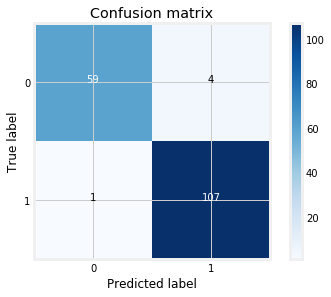

In [152]:
# specify parameters and distributions to sample from
tuned_parameters = {"n_estimators": [10, 20, 50, 100, 500], 
                    "max_depth": [3, 5, 10, 20], 
                    "max_features": [1, 3, 5, 10]
                    }

scores = ['f1']

clf = GridSearchCV(RandomForestClassifier(), 
                   tuned_parameters,
                   cv=5, n_jobs = -1, scoring='%s' % score)
clf.fit(X_train, y_train)
y_true, y_pred = y_test, clf.predict(X_test)

labels = [0, 1]

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Best score set found on development set:")
print()
print("Detailed classification report:")
print()
print(classification_report(y_true, y_pred))
print()
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes = np.array(["0", "1"]))  

## Question 4

Use a grid search to optimize the number of estimators and max_depth for a Gradient Boosted Decision tree using the Wisconsin breast cancer data. Plug this optimal ``max_depth`` into a *single* decision tree.  Does this single tree over-fit or under-fit the data? Repeat this for the Random Forest.  Construct a single decision tree using the ``max_depth`` which is optimal for the Random Forest.  Does this single tree over-fit or under-fit the data?

For parameters optimization in grid search, I choose to apply recall metric as scoring since it is most sensitive for patient features in cancer research.

### Gradient Boosted Decision tree

Optimize based on f1 metric

Best parameters set found on development set:

{'max_depth': 3, 'n_estimators': 300}

Best score set found on development set:

Detailed classification report:

             precision    recall  f1-score   support

          0       0.95      0.94      0.94        63
          1       0.96      0.97      0.97       108

avg / total       0.96      0.96      0.96       171




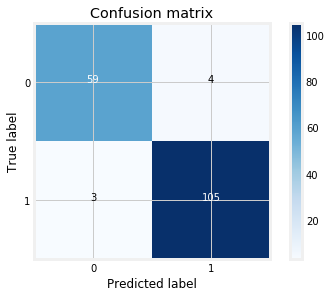

In [153]:
# Write your work here
from sklearn.ensemble import GradientBoostingClassifier

# specify parameters and distributions to sample from
tuned_parameters = {"n_estimators": [10, 20, 50, 100, 200, 300, 500, 1000], 
                    "max_depth": [3, 5, 10, 15, 20, 50] 
                    }

clf = GridSearchCV(GradientBoostingClassifier(), 
                   tuned_parameters,
                   cv=5, n_jobs = -1, scoring='recall')
clf.fit(X_train, y_train)
y_true, y_pred = y_test, clf.predict(X_test)

labels = [0, 1]

print("Optimize based on %s metric" % score)
print()
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Best score set found on development set:")
print()
print("Detailed classification report:")
print()
print(classification_report(y_true, y_pred))
print()
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes = np.array(["0", "1"])) 

Detailed classification report:

             precision    recall  f1-score   support

          0       0.95      0.94      0.94        63
          1       0.96      0.97      0.97       108

avg / total       0.96      0.96      0.96       171




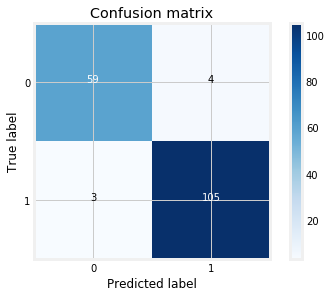

In [154]:
# check overfit or underfit
clf1 = GradientBoostingClassifier(n_estimators = 1, max_depth = 3)
clf1.fit(X_train, y_train)
y_true, y_pred = y_test, clf.predict(X_test)

labels = [0, 1]

print("Detailed classification report:")
print()
print(classification_report(y_true, y_pred))
print()
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes = np.array(["0", "1"])) 

From the above confusion matrix, we can conclude a single decision tree does not overfit for test data.

### Random Forest

Optimize based on f1 metric

Best parameters set found on development set:

{'max_depth': 5, 'n_estimators': 100}

Best score set found on development set:

Detailed classification report:

             precision    recall  f1-score   support

          0       0.97      0.94      0.95        63
          1       0.96      0.98      0.97       108

avg / total       0.96      0.96      0.96       171




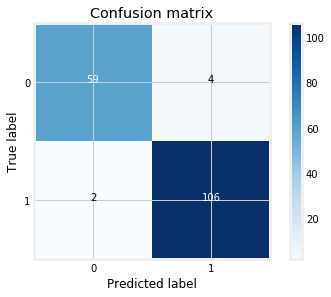

In [155]:
from sklearn.ensemble import RandomForestClassifier

# specify parameters and distributions to sample from
tuned_parameters = {"n_estimators": [10, 20, 50, 100, 200, 300, 500, 1000], 
                    "max_depth": [3, 5, 10, 15, 20, 50] 
                    }

clf = GridSearchCV(RandomForestClassifier(), 
                   tuned_parameters,
                   cv=5, n_jobs = -1, scoring='recall')
clf.fit(X_train, y_train)
y_true, y_pred = y_test, clf.predict(X_test)

labels = [0, 1]

print("Optimize based on %s metric" % score)
print()
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Best score set found on development set:")
print()
print("Detailed classification report:")
print()
print(classification_report(y_true, y_pred))
print()
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes = np.array(["0", "1"]))

Detailed classification report:

             precision    recall  f1-score   support

          0       0.97      0.94      0.95        63
          1       0.96      0.98      0.97       108

avg / total       0.96      0.96      0.96       171




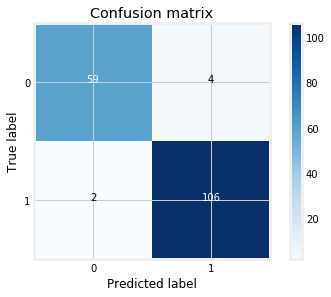

In [158]:
# check overfit or underfit
clf1 = RandomForestClassifier(n_estimators = 1, max_depth = 5)
clf1.fit(X_train, y_train)
y_true, y_pred = y_test, clf.predict(X_test)

labels = [0, 1]

print("Detailed classification report:")
print()
print(classification_report(y_true, y_pred))
print()
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes = np.array(["0", "1"])) 

From the above confusion matrix, we can conclude a single tree using Random Forest does not overfit for test data.